In [1]:
from keras import layers, Model,callbacks
import numpy as np
import matplotlib.pyplot as plt
import h5py

data_path = 'cleaned_with_top_4k_used/data.h5'
with h5py.File(data_path, 'r') as h:
    labeled_train = np.array(h['lableledTrainData'])
    test = np.array(h['testData'])
    labels = np.array(h['trainDataLabels'])
    unlabeled_train = np.array(h['unlableledTrainData'])
x = labeled_train
y = np.zeros((len(labels), 2))
y[np.arange(0, labels.shape[0]), labels] = 1

a = layers.Input(shape=(252,), dtype='float32')
embedding = layers.Embedding(input_dim=4003, output_dim=10, input_length=252)(a)
conv1 = layers.Convolution1D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu')(embedding)
pool=layers.GlobalAveragePooling1D()(conv1)
#rnn = layers.CuDNNLSTM(units=64, return_sequences=True,bias_regularizer='l1_l2')(conv1)
#conv2 = layers.Convolution1D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu')(rnn)
#pool=layers.AveragePooling1D(pool_size=12,strides=6)(conv2)
#flatten = layers.Flatten()(pool)
#dropout1 = layers.Dropout(0.5)(flatten)
dense1 = layers.Dense(units=512, activation='relu',kernel_regularizer='l2')(pool)
dropout2 = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(units=256, activation='relu')(dropout2)
dropout3 = layers.Dropout(0.5)(dense2)
b = layers.Dense(units=2, activation='softmax')(dropout2)
model = Model(a, b)
model.summary()
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(x, y, batch_size=512, epochs=1000, validation_split=0.2,callbacks=[early_stopping])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 252)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 252, 10)           40030     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 252, 128)          2688      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total para

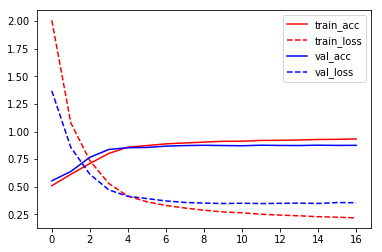

In [2]:
def plot_history(history):
    acc,val_acc,loss,val_loss = history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    epoch=range(1,len(acc)+1)
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(acc,'r',label='train_acc')
    ax.plot(loss,'r--',label='train_loss')
    ax.plot(val_acc,'b',label='val_acc')
    ax.plot(val_loss,'b--',label='val_loss')
    ax.legend()
plot_history(history)

In [3]:
unlabeled_labels=model.predict(unlabeled_train)
unlabeled_labels[unlabeled_labels>=0.5]=unlabeled_labels[unlabeled_labels>0.5]*history.history['acc'][-1]
unlabeled_labels[unlabeled_labels<0.5]=unlabeled_labels[unlabeled_labels<0.5]/history.history['acc'][-1]
unlabeled_labels[unlabeled_labels>=0.5]=1
unlabeled_labels[unlabeled_labels<0.5]=0

In [4]:
#with h5py.File(data_path) as h:
#    h.create_dataset('unlabeled_predict_labels',data=unlabeled_labels)
train_data=np.concatenate([labeled_train,unlabeled_train],axis=0)
train_labels=np.concatenate([y,unlabeled_labels],axis=0)

a_ = layers.Input(shape=(252,), dtype='float32')
embedding_ = layers.Embedding(input_dim=4003, output_dim=12, input_length=252)(a_)
conv1_ = layers.Convolution1D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu')(embedding_)
rnn_ = layers.CuDNNGRU(units=128, return_sequences=True,bias_regularizer='l2')(conv1_)
conv2_ = layers.Convolution1D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu')(rnn_)
pool_=layers.AveragePooling1D(pool_size=12,strides=6)(conv2_)
flatten_ = layers.Flatten()(pool_)
dropout1_ = layers.Dropout(0.5)(flatten_)
dense1_ = layers.Dense(units=128, activation='relu',kernel_regularizer='l2')(dropout1_)
dropout2_ = layers.Dropout(0.5)(dense1_)
#dense2 = layers.Dense(units=64, activation='relu')(dropout2)
#dropout3 = layers.Dropout(0.5)(dense2)
b_ = layers.Dense(units=2, activation='sigmoid')(dropout2_)
model_=Model(a_,b_)

model_.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
history=model_.fit(train_data, train_labels, batch_size=512, epochs=1000, validation_split=0.2,callbacks=[early_stopping])

Train on 55998 samples, validate on 14000 samples
Epoch 1/1000
55998/55998 [==============================] - 10s 180us/step - loss: 0.7360 - acc: 0.6199 - val_loss: 0.3511 - val_acc: 0.8785
Epoch 2/1000
55998/55998 [==============================] - 9s 162us/step - loss: 0.3365 - acc: 0.8738 - val_loss: 0.2500 - val_acc: 0.9014
Epoch 3/1000
55998/55998 [==============================] - 9s 162us/step - loss: 0.2474 - acc: 0.9119 - val_loss: 0.1651 - val_acc: 0.9440
Epoch 4/1000
55998/55998 [==============================] - 9s 161us/step - loss: 0.2078 - acc: 0.9283 - val_loss: 0.1618 - val_acc: 0.9341
Epoch 5/1000
55998/55998 [==============================] - 9s 161us/step - loss: 0.1924 - acc: 0.9361 - val_loss: 0.2217 - val_acc: 0.9049
Epoch 6/1000
55998/55998 [==============================] - 9s 161us/step - loss: 0.1813 - acc: 0.9400 - val_loss: 0.1229 - val_acc: 0.9554
Epoch 7/1000
55998/55998 [==============================] - 9s 161us/step - loss: 0.1738 - acc: 0.9425 - val_

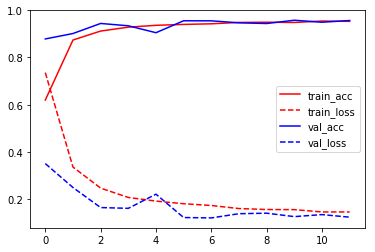

In [5]:
plot_history(history)

In [6]:
test_labels=model.predict(test)
test_labels[test_labels>=0.5]=1
test_labels[test_labels<0.5]=0
test_labels=np.argmax(test_labels,axis=1)
#with h5py.File(data_path) as h:
#    h.create_dataset('test_labels',data=test_labels)

In [7]:
test_labels

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [8]:
import pandas as pd
path='cleaned/testData.tsv'
iden=pd.read_csv(path,sep='\t',header=0)['id'].values

In [9]:
df=pd.DataFrame([iden,test_labels],index=['id','sentiment']).transpose()

In [10]:
df.to_csv('submission.csv',header=True,index=False)

# 86.08	submission.zip	12/19/2018 13:01:03	Finished		
# 85.32	submission.zip	12/19/2018 13:20:29	Finished		
# 87.14	submission.zip	12/19/2018 13:39:45	Finished	
# 87.04	submission.zip	12/19/2018 13:50:22	Finished